In [2]:

import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from image_transform_multiprocessing import image_transform
import torch.optim  as optim
from PIL import Image
from Utilities import MyDataset
from glob import glob
import os
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import torchvision
torchvision.disable_beta_transforms_warning()

device = 'cuda' if torch.cuda.is_available() else 'cpu'


%load_ext autoreload
%autoreload 2


C:\Users\0005h\miniconda3\envs\thesis\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
C:\Users\0005h\miniconda3\envs\thesis\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you

In [3]:
images_path = r'C:\my files\REFUGE'
train_images_path = 'Training400/**/*.jpg'
train_masks_path = 'Annotation-Training400/Disc_Cup_Masks/**/*.bmp'
val_images_path ='REFUGE-Validation400/**/*.jpg'
val_masks_path = 'REFUGE-Validation400-GT/**/*.bmp'

In [4]:
train_images = sorted(glob(os.path.join(images_path, train_images_path), recursive=True))
train_masks = sorted(glob(os.path.join(images_path, train_masks_path), recursive=True))
val_images = sorted(glob(os.path.join(images_path, val_images_path), recursive=True))
val_masks = sorted(glob(os.path.join(images_path, val_masks_path), recursive=True))

  0%|          | 0/400 [00:00<?, ?it/s]

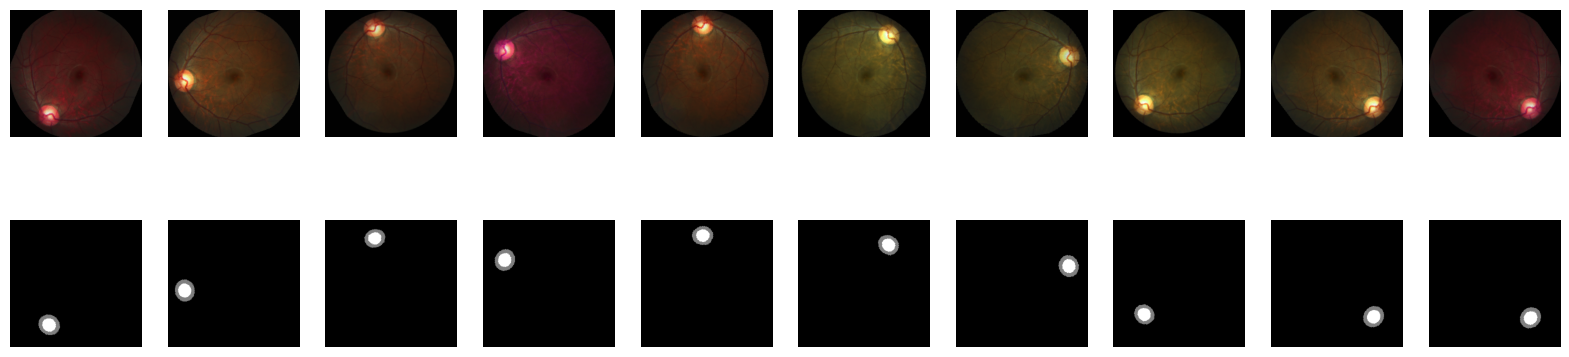

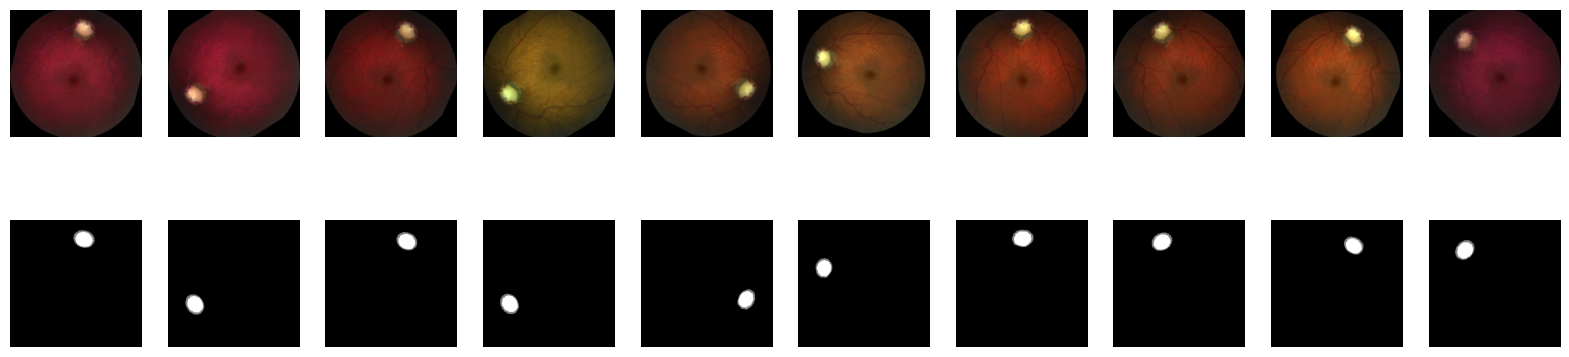

In [5]:
transformed_path = r'C:\my files\REFUGE\training'

for i, (image, label) in tqdm(enumerate(zip(train_images, train_masks)), total=len(train_masks)):

    images, labels = image_transform(image, label, 10, 256)
    if i < 2:
        fig, axs = plt.subplots(2, 10, figsize=(20, 5))

        for k in range(10):
            axs[0, k].imshow(images[k].permute(1, 2, 0))
            axs[0, k].axis('off')

        for k in range(10):
            axs[1, k].imshow(labels[k].permute(1, 2, 0), cmap = 'gray')
            axs[1, k].axis('off')
    else:
        break


In [11]:
train_masks =  sorted(glob(os.path.join(transformed_path, r'masks/**/*.bmp'), recursive=True))
train_images = sorted(glob(os.path.join(transformed_path, r'input/**/*.jpg'), recursive=True))

train_dataset = MyDataset(train_images[:200], train_masks[:200])
val_dataset = MyDataset(val_images, val_masks)
train_loader = DataLoader(train_dataset, batch_size=16)
val_loader = DataLoader(val_dataset, batch_size=16)

In [12]:
class SegmentationModel(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SegmentationModel, self).__init__()

        # Encoder
        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(32, 16, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(16)
        self.upconv2 = nn.ConvTranspose2d(16, out_channels , kernel_size=5, stride=2)


    def forward(self, x):
        x_size = x.size()
        # Encoder
        x = F.relu(self.pool(self.bn1(self.conv1(x))))
        x = F.relu(self.pool(self.bn2(self.conv2(x))))

        x = F.relu(self.pool(self.bn3(self.upconv1(x))))
        x = F.relu(self.pool(self.upconv2(x)))


        x = F.interpolate(x, x_size[2:], mode='bilinear', align_corners=True)

        return torch.squeeze(x)

In [18]:
import torch.optim as optim

# Define your model
model = SegmentationModel(in_channels=3, out_channels=1).to(device)

# Define your loss function
criterion = nn.BCEWithLogitsLoss().to(device)

# Define your optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define number of epochs
num_epochs = 10

# Train the model
torch.cuda.empty_cache()
for epoch in range(num_epochs):
    # Train
    model.train()
    train_loss = 0.0
    for images, masks in tqdm(train_loader):
        images = images.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # Validate
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
        val_loss /= len(val_loader)

    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


  0%|          | 0/13 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.55 GiB (GPU 0; 4.00 GiB total capacity; 1.44 GiB already allocated; 1.07 GiB free; 1.60 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [15]:
torch.cuda.empty_cache()

In [17]:
hmm='wow'